# Árboles de decisión

En este notebook estudiaremos cómo crear y visualizar árboles de decisión en scikit-learn. 

In [1]:
RANDOM_STATE=83

## Conjunto de datos

En este notebook vamos a usar el conjunto de datos sobre flores Iris que ya conocemos.

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Cargamos el dataset del iris
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [ ]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Como vamos a utilizar árboles de decisión, __no__ es necesario reescalar los datos.

## Dibujar el árbol de decisión

Vamos a construir un árbol de decisión usando los parámetros por defecto y a dibujarlo para analizar cuales son las variables más importantes (las que mejor discriminan).

In [4]:
# Creamos un árbol de decisión con la configuración por defecto y lo entrenamos
clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf = clf.fit(iris['data'], iris['target'])

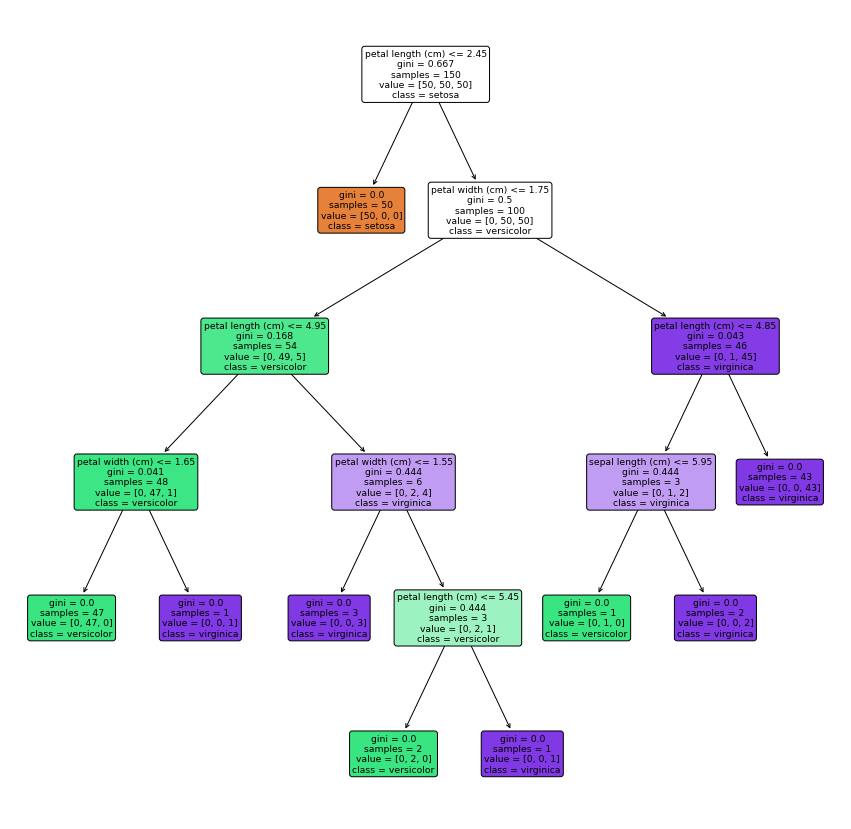

In [5]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Pintamos el árbol
plt.figure(figsize=(15,15))
plot_tree(clf, filled=True, feature_names=iris['feature_names'], class_names=iris['target_names'], rounded=True)
plt.show()

El algortimo que se usa para construir el árbol hace que los primeros niveles del árbol contengan las variables que mejor discriminan las clases que estamos tratando de modelar. En este caso serían "petal length (cm)" y "petal width (cm)". De hecho, podemos observar que la variable "petal length (cm)" permite separar por si mima la clase de las setosas.

También podemos observar que el árbol termina separando todas las clases perfectamente porque ninguna de sus hojas tiene ejemplos de dos clases distintas. ¡Ojo! esto no quiere decir que el árbol sea un clasificador perfecto, sólo significa que clasifica de forma perfecta el conjunto de datos que hemos usado para entrenarlo (puede haber sobreaprendido).

En esta imagen puedes ver una de las grandes ventajas de los árboles de decisión: construyen __modelos fácilmente interpretables__. Al menos para tamaños manejables.

En el algoritmo que hemos visto en clase usamos la _entropía_ como métrica para elegir la siguiente mejor variable. En sklearn, por defecto, usan el [Índice de Gini](https://medium.com/analytics-steps/understanding-the-gini-index-and-information-gain-in-decision-trees-ab4720518ba8) que es una métrica alternativa que persigue el mismo objetivo. En cualquier caso, al construir el árbol de decisión podemos elegir cual de las dos métricas queremos utilizar.

## Estimando la tasa de acierto

Podemos comenzar midiendo el error de nuestro clasificador haciendo una partición del conjunto de datos en dos partes: entrenamiento y test.

In [ ]:
from sklearn.model_selection import train_test_split

# Partimos el conjunto de datos en entrenamiento (70%) y test (30%)
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], test_size=0.3, random_state=RANDOM_STATE)

# Creamos y entrenamos el árbol de decisión con los parámetros por defecto
clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf = clf.fit(X_train, y_train)

# Calculamos la precisión del modelo de entrenamiento y de test
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
train_accuracy, test_accuracy

(1.0, 0.9111111111111111)

Podemos observar como el árbol clasifica perfectamente el conjunto de entrenamiento pero no lo hace tan bien con el conjunto de test. Parece que nuestro modelo ha sobreaprendido.

Si queremos tener unos valores más confiables del error podemos utilizar validación cruzada. Aunque la validación cruzada es mucho más costosa computacionalmente, en este caso no notaremos la diferencia porque el conjunto de datos es muy pequeño.

In [6]:
from sklearn.model_selection import cross_validate
import numpy as np

# Creamos y entrenamos el árbol de decisión con los parámetros por defecto
clf = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Validación cruzada dividiendo el conjunto de datos en 10 partes (folds)
scores = cross_validate(clf, iris['data'], iris['target'], scoring='accuracy', 
                        cv=10, return_train_score=True)

# scores es un diccionario con datos sobre tiempos y exactitud (accuracy)
train_accuracy = np.mean(scores['train_score'])
test_accuracy = np.mean(scores['test_score'])
train_accuracy, test_accuracy

(1.0, 0.9533333333333334)

Podemos ver como, en realidad, el árbol se comporta un poco mejor de lo que parecía con la partición simple. Tenemos un 95.33% de exactitud (accuracy) en el conjunto de test.

¿Podemos hacerlo mejor configurando el árbol de decisión? Hay varios parámetros que podemos configurar:

- criterio de selección de variables: entropía o gini.
- profundidad máxima del árbol
- mínimo número de muestras de un nodo para seguir dividiendo 
- etc.

In [7]:
# Repetimos el proceso pero modificando los parámetros de aprendizaje del árbol
clf = DecisionTreeClassifier(criterion="entropy",  # por defecto Gini pero podemos cambiar a entropía
                             max_depth=4,          # profundidad máxima del árbol
                             min_samples_split=5,  # mínimo de muestras en el nodo para seguir dividiéndolo
                             random_state=RANDOM_STATE)

# Validación cruzada dividiendo el conjunto de datos en 10 partes (folds)
scores = cross_validate(clf, iris['data'], iris['target'], scoring='accuracy', 
                        cv=10, return_train_score=True)

train_accuracy = np.mean(scores['train_score'])
test_accuracy = np.mean(scores['test_score'])
train_accuracy, test_accuracy

(0.9844444444444445, 0.96)

Este árbol parece un poco menos sobreajustado que el anterior. Mejora ligeramente la exactitud en el conjunto de test y no tiene un valor tan alto en el conjunto de entrenamiento.

## Optimizando los parámetros de un clasificador

Hay parámetros que nos sirven para ajustar la capacidad de aprendizaje del árbol de decisión. Podemos ver los que están disponibles en [la implementación de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). Lo que hacen  es podar el subsiguiente desarrollo de una rama, si sus nodos hijos no cumplen un determinado criterio. Estos son `min_impurity_decrease` (que fija un valor mínimo de mejora que la partición en nodos hijos debe superar), `min_samples_split` que solamente subdivide un nodo si alcanza el número mínimo de ejemplos, o `min_samples_leaf` que solamente genera una partición si las hojas que genera tienen superan un valor mínimo de ejemplos.

Otra forma menos sutil de regular el aprendizaje consiste en limitar la profundidad máxima del árbol de decisión. Esto nos hará obtener un clasificador menos "ajustado" a los datos de entrenamiento con la esperanza de que generalice mejor en datos nuevos.

Podemos calcular la profundidad optima usando validación cruzada y probando distintos valores de ese parámetro.

In [8]:
train_accuracy = []
test_accuracy = []

# Entrenamos y validamos varios árboles con distintas profundidades máximas
max_depths = range(1, 6)
for md in max_depths: 
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=md, min_samples_split=2, random_state=RANDOM_STATE)
    scores = cross_validate(clf, iris['data'], iris['target'], scoring='accuracy', cv=10, return_train_score=True)
    
    train_accuracy.append(np.mean(scores['train_score']))
    test_accuracy.append(np.mean(scores['test_score']))
    
train_accuracy, test_accuracy

([0.6666666666666667,
  0.96,
  0.9733333333333333,
  0.9925925925925926,
  0.9992592592592592],
 [0.6666666666666667, 0.9533333333333334, 0.96, 0.96, 0.9533333333333334])

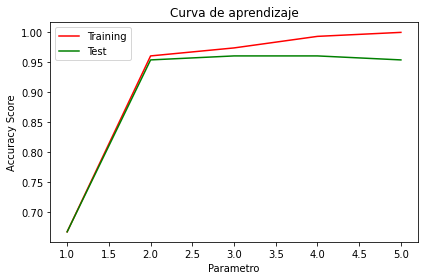

In [9]:
import matplotlib.pyplot as plt

# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

Para max_depth=3 obtenemos el mejor valor de exactitud para el conjunto de test. A partir de esa profundidad la métrica mejora para el conjunto de entrenamiento y empeora para el conjunto de test indicando que el clasificador está sobre-entrenado y generaliza peor.

Podríamos hacer lo mismo con el resto de parámetros del árbol hasta encontrar lo que funcionan mejor para nuestro conjunto de datos.

## Métricas detalladas por clase

Primero vamos a calcular las métricas detalladas agregadas.

In [10]:
# Importamos las métricas que vamos a evaluar para cada una de las clases
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Escribimos las métricas que queremos evaluar
scoring_metrics = ['precision_weighted', 'recall_weighted','f1_weighted']

# Construimos el clasificador
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=2, random_state=RANDOM_STATE)

# Calculamos las métricas utilizando validación cruzada
scores = cross_validate(clf, iris['data'], iris['target'], scoring=scoring_metrics, 
                        cv=10, return_train_score=False)

# Mostrar las métricas agregadas
print('Precisión ponderada media: ',np.mean(scores['test_precision_weighted']))
print('Exhaustividad ponderada media: ',np.mean(scores['test_recall_weighted']))
print('F1 ponderado media: ',np.mean(scores['test_f1_weighted']))

Precisión ponderada media:  0.9666666666666668
Exhaustividad ponderada media:  0.96
F1 ponderado media:  0.9595959595959596


A continuación calculamos las métricas detalladas por clase.

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

# Esta función entrena 10 clasificadores usando validación cruzada y devuelve una predicción
# para cada punto usando el clasificador que no fue entrenado con ese punto
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=2, random_state=RANDOM_STATE)
predictions = cross_val_predict(clf, iris['data'], iris['target'], cv=10)

# Informe por clases
cr = classification_report(iris['target'],predictions, target_names=iris['target_names'])
print(cr)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.94      0.94      0.94        50
   virginica       0.94      0.94      0.94        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



Como habíamos visto en el dibujo del árbol, la clase de las setosas se puede clasificar perfectamente. En las clases versicolor y virginica obtenemos una precisión y exahustividad del 94%.

Finalmente vamos a pintar la matriz de confusión.

In [12]:
# Función extraída de
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization
[[50  0  0]
 [ 0 47  3]
 [ 0  3 47]]


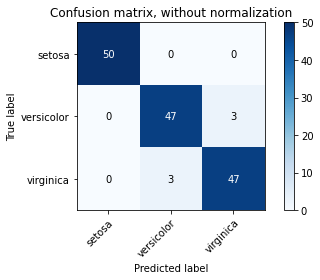

In [13]:
# El parámetro normalize permite mostrar los porcentajes en lugar del número de instancias
plot_confusion_matrix(iris['target'], predictions, iris['target_names'], normalize=False)

## Entrenando el clasificador final

Una vez hemos determinado la mejor combinación de parámetros del clasificador (evitando sobreaprender) y hemos calculado cuál es el rendimiento esperable del modelo (usando por ejemplo validación cruzada), podemos entrenar un nuevo modelo con todos los datos y usarlo en "producción" cuando nos lleguen nuevos datos.

En el caso de los árboles, también puede ser interesante para visualizar el modelo y determinar las variables más importantes.

In [14]:
# Suponemos la siguiente combinación como la mejor (probablemente no es cierto)
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=2, random_state=RANDOM_STATE)
clf = clf.fit(iris.data, iris.target)

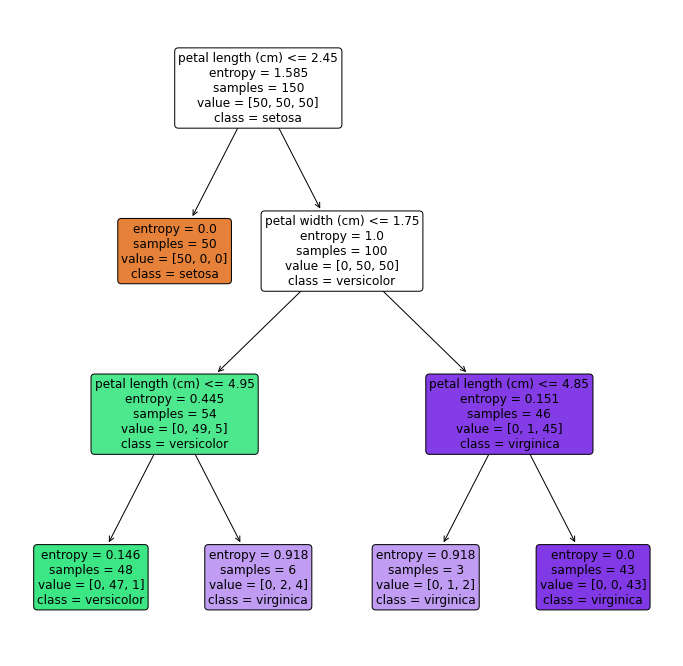

In [15]:
# Pintamos el árbol
plt.figure(figsize=(12,12))
plot_tree(clf, filled=True, feature_names=iris['feature_names'], class_names=iris['target_names'], rounded=True)
plt.show()

Podemos observar como nuestro árbol "optimo" tiene hojas no puras que contiene ejemplos de varias clase. En esos casos el clasificador elegirá la clase mayoritaria para hacer la predicción.

En la siguiente celda puedes ver como podríamos usar este clasificador para predecir la clase de un nuevo ejemplo.

In [16]:
# Predecimos el valor de un ejemplo que nunca hemos visto
# podemos pasar un array de nuevos ejemplos y nos devolverá un array de clases
clase = clf.predict([[5, 3, 1, 0.1]])
# Nos da la clase 0 que es setosa
clase[0], iris['target_names'][clase[0]]

(0, 'setosa')

Aunque no es nuestro caso, porque el árbol es pequeño, pero muchas veces cuesta calibrar qué variables juegan un papel importante en el mismo. La importancia de una variable puede medirse como la agregación ponderada de las ganancias de información que ocasionó su uso en el árbol.

Veamos cómo podemos obtener y mostrar dichos valores con sklearn.

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.68977
Feature: 3, Score: 0.31023


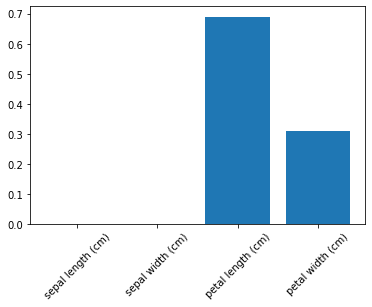

In [24]:
from matplotlib import pyplot as plt

importance = clf.feature_importances_
# summarize feature importance



for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
feature_names=iris['feature_names']
plt.bar([x for x in range(len(importance))], importance, tick_label = feature_names)
plt.xticks(rotation = 45) 
plt.show()